# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

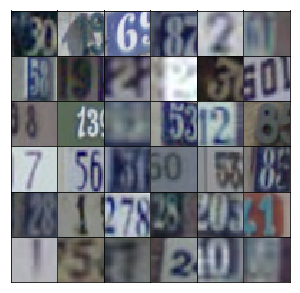

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        logits = tf.layers.dense(tf.reshape(x3, (-1, 4*4*256)), 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 1024
epochs = 20
alpha = 0.3
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/20... Discriminator Loss: 2.5908... Generator Loss: 0.2575
Epoch 1/20... Discriminator Loss: 0.4211... Generator Loss: 2.5168
Epoch 1/20... Discriminator Loss: 0.2683... Generator Loss: 2.2359
Epoch 1/20... Discriminator Loss: 0.2659... Generator Loss: 2.1601
Epoch 1/20... Discriminator Loss: 0.1479... Generator Loss: 2.8258
Epoch 1/20... Discriminator Loss: 0.2666... Generator Loss: 2.0136
Epoch 1/20... Discriminator Loss: 0.8268... Generator Loss: 1.1495
Epoch 2/20... Discriminator Loss: 0.8277... Generator Loss: 1.4147
Epoch 2/20... Discriminator Loss: 1.1730... Generator Loss: 2.2715
Epoch 2/20... Discriminator Loss: 0.6511... Generator Loss: 1.0972


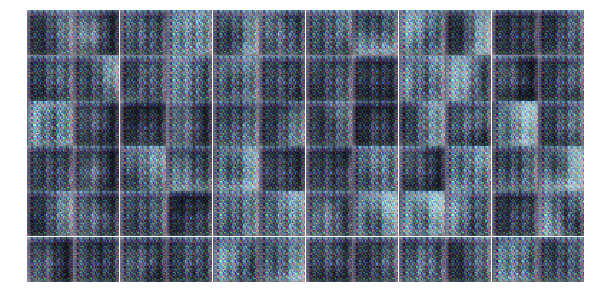

Epoch 2/20... Discriminator Loss: 0.5726... Generator Loss: 1.4448
Epoch 2/20... Discriminator Loss: 0.4917... Generator Loss: 1.8249
Epoch 2/20... Discriminator Loss: 0.3884... Generator Loss: 1.9504
Epoch 2/20... Discriminator Loss: 0.4917... Generator Loss: 1.4386
Epoch 3/20... Discriminator Loss: 0.3758... Generator Loss: 2.0294
Epoch 3/20... Discriminator Loss: 0.5487... Generator Loss: 1.4300
Epoch 3/20... Discriminator Loss: 0.3113... Generator Loss: 2.7784
Epoch 3/20... Discriminator Loss: 2.3030... Generator Loss: 6.2381
Epoch 3/20... Discriminator Loss: 0.8456... Generator Loss: 2.8500
Epoch 3/20... Discriminator Loss: 1.1030... Generator Loss: 1.3558


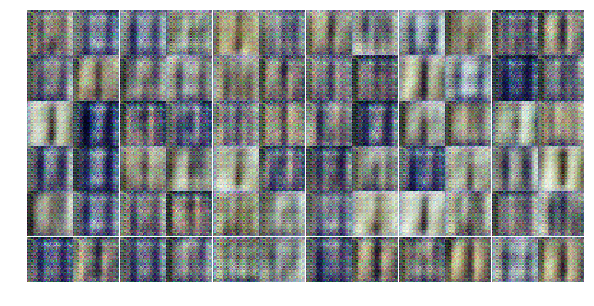

Epoch 3/20... Discriminator Loss: 1.8661... Generator Loss: 0.2683
Epoch 4/20... Discriminator Loss: 0.4075... Generator Loss: 4.4120
Epoch 4/20... Discriminator Loss: 0.9815... Generator Loss: 0.7018
Epoch 4/20... Discriminator Loss: 1.7296... Generator Loss: 0.2889
Epoch 4/20... Discriminator Loss: 1.3950... Generator Loss: 2.6374
Epoch 4/20... Discriminator Loss: 1.1668... Generator Loss: 0.8152
Epoch 4/20... Discriminator Loss: 0.6013... Generator Loss: 2.3637
Epoch 4/20... Discriminator Loss: 0.7529... Generator Loss: 0.9656
Epoch 5/20... Discriminator Loss: 1.0685... Generator Loss: 1.5584
Epoch 5/20... Discriminator Loss: 0.5372... Generator Loss: 1.4061


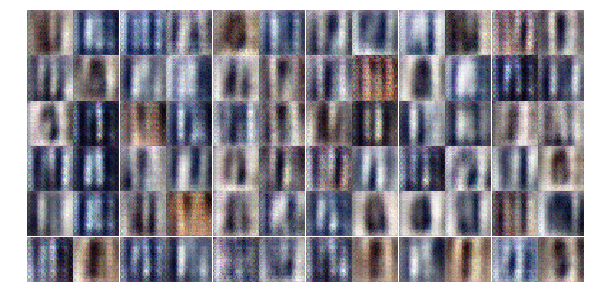

Epoch 5/20... Discriminator Loss: 0.8043... Generator Loss: 1.1478
Epoch 5/20... Discriminator Loss: 0.3158... Generator Loss: 2.0334
Epoch 5/20... Discriminator Loss: 1.8776... Generator Loss: 0.2893
Epoch 5/20... Discriminator Loss: 0.6438... Generator Loss: 2.2743
Epoch 5/20... Discriminator Loss: 0.5022... Generator Loss: 1.2488
Epoch 5/20... Discriminator Loss: 1.4876... Generator Loss: 0.6113
Epoch 6/20... Discriminator Loss: 0.6345... Generator Loss: 1.4999
Epoch 6/20... Discriminator Loss: 0.7207... Generator Loss: 1.5561
Epoch 6/20... Discriminator Loss: 1.8312... Generator Loss: 0.2664
Epoch 6/20... Discriminator Loss: 0.7804... Generator Loss: 3.0073


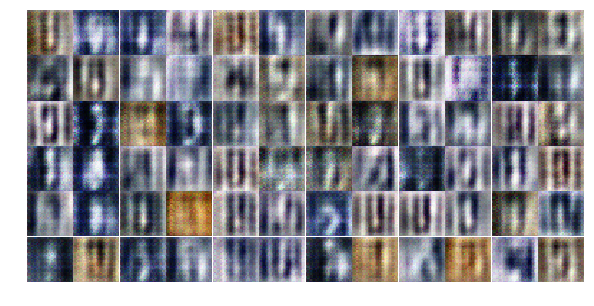

Epoch 6/20... Discriminator Loss: 0.4604... Generator Loss: 2.5998
Epoch 6/20... Discriminator Loss: 0.7544... Generator Loss: 0.9744
Epoch 6/20... Discriminator Loss: 0.5642... Generator Loss: 1.6036
Epoch 7/20... Discriminator Loss: 0.6063... Generator Loss: 2.1461
Epoch 7/20... Discriminator Loss: 0.5669... Generator Loss: 1.6365
Epoch 7/20... Discriminator Loss: 0.8596... Generator Loss: 1.6127
Epoch 7/20... Discriminator Loss: 0.9189... Generator Loss: 0.7615
Epoch 7/20... Discriminator Loss: 0.7506... Generator Loss: 1.5024
Epoch 7/20... Discriminator Loss: 0.7487... Generator Loss: 1.8088
Epoch 7/20... Discriminator Loss: 0.7848... Generator Loss: 1.4295


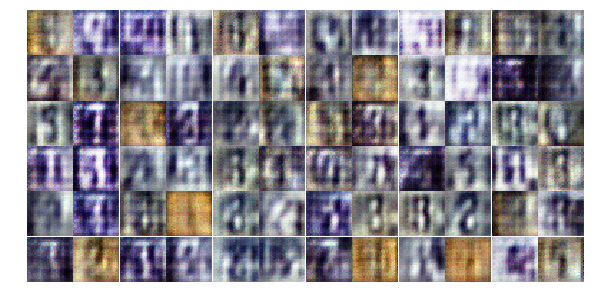

Epoch 8/20... Discriminator Loss: 0.6506... Generator Loss: 2.1474
Epoch 8/20... Discriminator Loss: 0.8415... Generator Loss: 1.6893
Epoch 8/20... Discriminator Loss: 0.6623... Generator Loss: 1.7497
Epoch 8/20... Discriminator Loss: 0.8379... Generator Loss: 1.1102
Epoch 8/20... Discriminator Loss: 1.3491... Generator Loss: 0.4348
Epoch 8/20... Discriminator Loss: 0.6535... Generator Loss: 1.3522
Epoch 8/20... Discriminator Loss: 0.6536... Generator Loss: 1.2835
Epoch 9/20... Discriminator Loss: 1.1169... Generator Loss: 0.8359
Epoch 9/20... Discriminator Loss: 1.3754... Generator Loss: 0.4129
Epoch 9/20... Discriminator Loss: 0.5420... Generator Loss: 2.5282


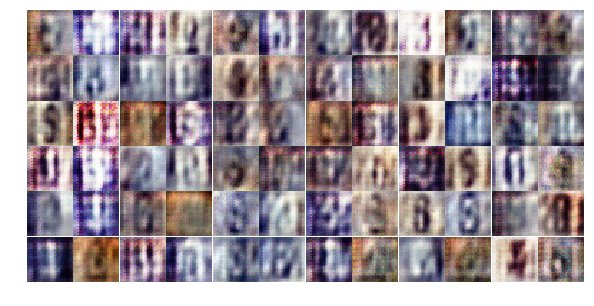

Epoch 9/20... Discriminator Loss: 0.9341... Generator Loss: 3.3570
Epoch 9/20... Discriminator Loss: 0.6859... Generator Loss: 1.8897
Epoch 9/20... Discriminator Loss: 0.7052... Generator Loss: 1.8338
Epoch 9/20... Discriminator Loss: 1.1800... Generator Loss: 0.5675
Epoch 10/20... Discriminator Loss: 0.8555... Generator Loss: 1.2965
Epoch 10/20... Discriminator Loss: 0.5638... Generator Loss: 1.3076
Epoch 10/20... Discriminator Loss: 0.6421... Generator Loss: 1.0325
Epoch 10/20... Discriminator Loss: 0.9255... Generator Loss: 3.8164
Epoch 10/20... Discriminator Loss: 1.0572... Generator Loss: 0.6050
Epoch 10/20... Discriminator Loss: 1.4247... Generator Loss: 4.0454


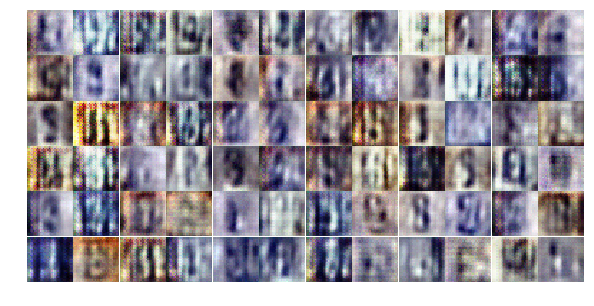

Epoch 10/20... Discriminator Loss: 0.9025... Generator Loss: 1.0166
Epoch 10/20... Discriminator Loss: 0.5426... Generator Loss: 2.6756
Epoch 11/20... Discriminator Loss: 0.9592... Generator Loss: 3.7135
Epoch 11/20... Discriminator Loss: 0.4041... Generator Loss: 2.4001
Epoch 11/20... Discriminator Loss: 0.6050... Generator Loss: 1.1040
Epoch 11/20... Discriminator Loss: 0.7026... Generator Loss: 1.0515
Epoch 11/20... Discriminator Loss: 0.6319... Generator Loss: 1.2264
Epoch 11/20... Discriminator Loss: 0.8214... Generator Loss: 0.7430
Epoch 11/20... Discriminator Loss: 0.3043... Generator Loss: 1.8855
Epoch 12/20... Discriminator Loss: 1.8808... Generator Loss: 0.4367


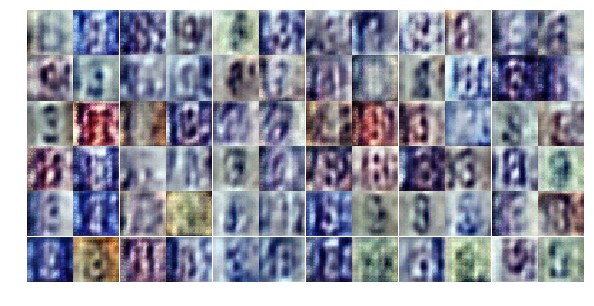

Epoch 12/20... Discriminator Loss: 1.5987... Generator Loss: 0.3101
Epoch 12/20... Discriminator Loss: 1.0468... Generator Loss: 2.2222
Epoch 12/20... Discriminator Loss: 1.1606... Generator Loss: 0.4754
Epoch 12/20... Discriminator Loss: 0.4394... Generator Loss: 1.4579
Epoch 12/20... Discriminator Loss: 1.0784... Generator Loss: 0.6221
Epoch 12/20... Discriminator Loss: 0.8834... Generator Loss: 4.5950
Epoch 13/20... Discriminator Loss: 0.7986... Generator Loss: 4.5270
Epoch 13/20... Discriminator Loss: 0.6028... Generator Loss: 1.0291
Epoch 13/20... Discriminator Loss: 1.4694... Generator Loss: 0.3376
Epoch 13/20... Discriminator Loss: 0.2804... Generator Loss: 2.9024


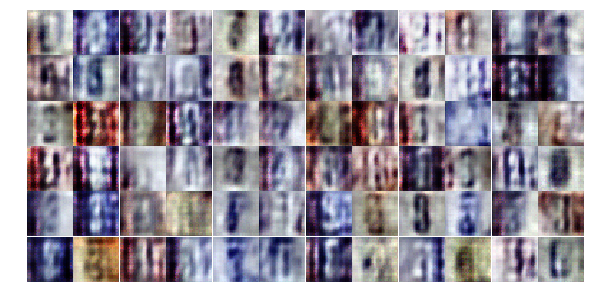

Epoch 13/20... Discriminator Loss: 1.2696... Generator Loss: 0.4271
Epoch 13/20... Discriminator Loss: 0.3464... Generator Loss: 5.2422
Epoch 13/20... Discriminator Loss: 0.5173... Generator Loss: 1.6786
Epoch 14/20... Discriminator Loss: 0.4845... Generator Loss: 1.5058
Epoch 14/20... Discriminator Loss: 0.3317... Generator Loss: 1.5996
Epoch 14/20... Discriminator Loss: 0.5464... Generator Loss: 1.2078
Epoch 14/20... Discriminator Loss: 0.2420... Generator Loss: 6.1081
Epoch 14/20... Discriminator Loss: 0.4005... Generator Loss: 1.7010
Epoch 14/20... Discriminator Loss: 1.2728... Generator Loss: 0.3968
Epoch 14/20... Discriminator Loss: 0.3978... Generator Loss: 5.6220


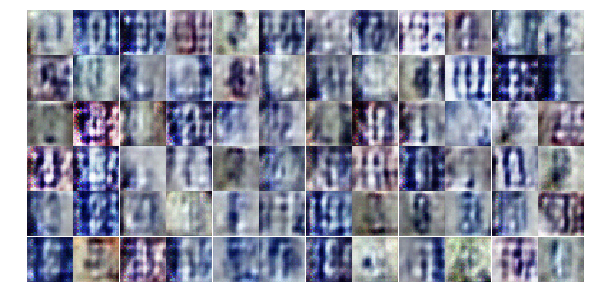

Epoch 15/20... Discriminator Loss: 0.1875... Generator Loss: 2.4742
Epoch 15/20... Discriminator Loss: 0.4271... Generator Loss: 2.1175
Epoch 15/20... Discriminator Loss: 0.3281... Generator Loss: 1.6547
Epoch 15/20... Discriminator Loss: 0.1720... Generator Loss: 3.3606
Epoch 15/20... Discriminator Loss: 0.1596... Generator Loss: 2.8785
Epoch 15/20... Discriminator Loss: 0.2252... Generator Loss: 3.6112
Epoch 15/20... Discriminator Loss: 0.1680... Generator Loss: 3.4418
Epoch 15/20... Discriminator Loss: 0.1805... Generator Loss: 3.0351
Epoch 16/20... Discriminator Loss: 0.8841... Generator Loss: 4.7919
Epoch 16/20... Discriminator Loss: 1.7197... Generator Loss: 3.5452


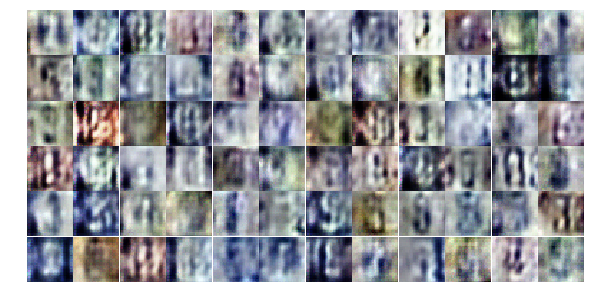

Epoch 16/20... Discriminator Loss: 1.0865... Generator Loss: 0.5556
Epoch 16/20... Discriminator Loss: 0.3428... Generator Loss: 1.7780
Epoch 16/20... Discriminator Loss: 0.1080... Generator Loss: 4.9214
Epoch 16/20... Discriminator Loss: 0.2330... Generator Loss: 4.4008
Epoch 16/20... Discriminator Loss: 0.2211... Generator Loss: 2.5481
Epoch 17/20... Discriminator Loss: 0.5372... Generator Loss: 1.2624
Epoch 17/20... Discriminator Loss: 0.9213... Generator Loss: 0.7267
Epoch 17/20... Discriminator Loss: 0.2989... Generator Loss: 4.5647
Epoch 17/20... Discriminator Loss: 0.2519... Generator Loss: 4.5948
Epoch 17/20... Discriminator Loss: 0.7712... Generator Loss: 0.8962


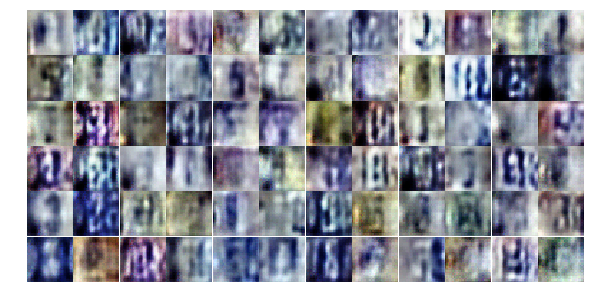

Epoch 17/20... Discriminator Loss: 0.2272... Generator Loss: 2.4739
Epoch 17/20... Discriminator Loss: 0.8590... Generator Loss: 0.7094
Epoch 18/20... Discriminator Loss: 0.1601... Generator Loss: 6.5139
Epoch 18/20... Discriminator Loss: 0.1790... Generator Loss: 2.7686
Epoch 18/20... Discriminator Loss: 0.1268... Generator Loss: 4.0380
Epoch 18/20... Discriminator Loss: 0.3869... Generator Loss: 2.0747
Epoch 18/20... Discriminator Loss: 0.2198... Generator Loss: 3.7670
Epoch 18/20... Discriminator Loss: 0.2984... Generator Loss: 1.7960
Epoch 18/20... Discriminator Loss: 0.1190... Generator Loss: 3.5301
Epoch 19/20... Discriminator Loss: 0.1793... Generator Loss: 2.8484


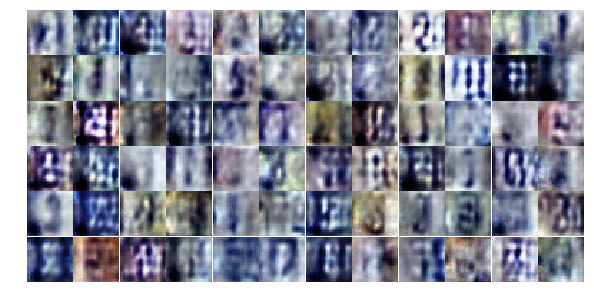

Epoch 19/20... Discriminator Loss: 0.6150... Generator Loss: 1.1313
Epoch 19/20... Discriminator Loss: 0.1596... Generator Loss: 2.9315
Epoch 19/20... Discriminator Loss: 0.5198... Generator Loss: 3.5387
Epoch 19/20... Discriminator Loss: 0.8952... Generator Loss: 0.6778
Epoch 19/20... Discriminator Loss: 0.1483... Generator Loss: 4.8082
Epoch 19/20... Discriminator Loss: 0.1607... Generator Loss: 2.8201
Epoch 20/20... Discriminator Loss: 1.2357... Generator Loss: 0.5476
Epoch 20/20... Discriminator Loss: 0.4520... Generator Loss: 6.1415
Epoch 20/20... Discriminator Loss: 0.1132... Generator Loss: 4.0387
Epoch 20/20... Discriminator Loss: 1.0268... Generator Loss: 3.8247


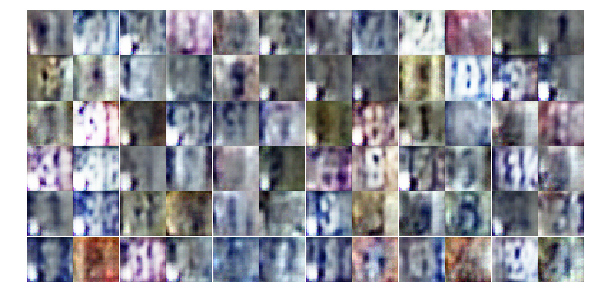

Epoch 20/20... Discriminator Loss: 0.1194... Generator Loss: 3.6763
Epoch 20/20... Discriminator Loss: 0.1838... Generator Loss: 2.7993
Epoch 20/20... Discriminator Loss: 0.2039... Generator Loss: 2.5283
Epoch 20/20... Discriminator Loss: 0.2172... Generator Loss: 2.4356


In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

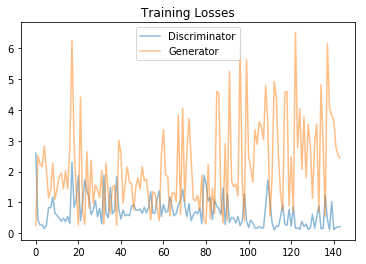

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

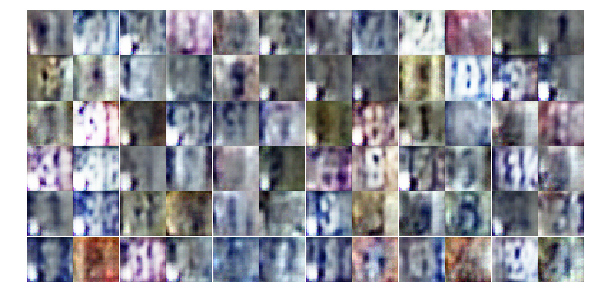

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))